In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import sys
sys.path.append("..")
from src.functions_analysis import *

# Import data

In [105]:
sumtable = pd.read_excel("../../data/summary_table_all.xlsx")
sumtable.drop('Unnamed: 0', axis = 1,inplace = True)

scraped_data = pd.read_csv("../../data/data_from_scrapy.csv")

#length
len(sumtable),len(scraped_data)

(5771, 5771)

In [106]:
scraped_data.head(3)

,case_brief,case_name,case_status,class_period_end,class_period_start,company_market,court,date_filed,date_of_last_review,docket,...,fic_links_list,fic_summary_table,headquarters,industry,judge,market_status,plaintiffs,sector,ticker_symbol,url
0,"According to the Complaint, Wirecard is a tech...",Wirecard AG Securities Litigation,ONGOING,6/24/20,8/17/15,OTC-BB,E.D. Pennsylvania,7/7/20,7/8/20,20-CV-03326,...,http://securities.stanford.edu/filings-documen...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",Germany,Software & Programming,Hon. ANITA B. BRODY,Public (Listed),"The Rosen Law Firm, P.A. (Jenkintown)",Technology,WCAGY,http://securities.stanford.edu/filings-case.ht...
1,"According to the Complaint, Finjan Holdings, I...","Finjan Holdings, Inc. Securities Litigation",ONGOING,6/29/20,6/10/20,NASDAQ,N.D. California,6/29/20,6/30/20,20-CV-04289,...,http://securities.stanford.edu/filings-documen...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",United States,Software & Programming,Hon. Edward M. Chen,Public (Listed),"Brodsky & Smith, LLC (California)",Technology,FNJN,http://securities.stanford.edu/filings-case.ht...
2,"According to the Complaint, Chembio Diagnostic...","Chembio Diagnostics, Inc. Securities Litigation",ONGOING,7/1/20,6/16/20,NASDAQ,E.D. New York,7/1/20,7/3/20,20-CV-02918,...,http://securities.stanford.edu/filings-documen...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",United States,Biotechnology & Drugs,Hon. Sandra J. Feuerstein,Public (Listed),Fields Kupka & Shukurov LLP\n\t\t\t\t\t\t\t\t\...,Healthcare,CEMI,http://securities.stanford.edu/filings-case.ht...


# Data Prepossing

In [107]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

In [108]:
sumtable["case_id"] = sumtable.index
scraped_data["case_id"] = scraped_data.index

In [109]:
scraped_data.head(2)

,case_brief,case_name,case_status,class_period_end,class_period_start,company_market,court,date_filed,date_of_last_review,docket,...,fic_summary_table,headquarters,industry,judge,market_status,plaintiffs,sector,ticker_symbol,url,case_id
0,"According to the Complaint, Wirecard is a tech...",Wirecard AG Securities Litigation,ONGOING,6/24/20,8/17/15,OTC-BB,E.D. Pennsylvania,7/7/20,7/8/20,20-CV-03326,...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",Germany,Software & Programming,Hon. ANITA B. BRODY,Public (Listed),"The Rosen Law Firm, P.A. (Jenkintown)",Technology,WCAGY,http://securities.stanford.edu/filings-case.ht...,0
1,"According to the Complaint, Finjan Holdings, I...","Finjan Holdings, Inc. Securities Litigation",ONGOING,6/29/20,6/10/20,NASDAQ,N.D. California,6/29/20,6/30/20,20-CV-04289,...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",United States,Software & Programming,Hon. Edward M. Chen,Public (Listed),"Brodsky & Smith, LLC (California)",Technology,FNJN,http://securities.stanford.edu/filings-case.ht...,1


In [110]:
scraped_data.columns

Index(['case_brief', 'case_name', 'case_status', 'class_period_end',
       'class_period_start', 'company_market', 'court', 'date_filed',
       'date_of_last_review', 'docket', 'fic_doc_links', 'fic_links_list',
       'fic_summary_table', 'headquarters', 'industry', 'judge',
       'market_status', 'plaintiffs', 'sector', 'ticker_symbol', 'url',
       'case_id'],
      dtype='object')

## Subsetting to data with no NA values

In [111]:
#subset the data to features needed
noNA = ["case_brief",
        "case_id",
        "case_status",
        "class_period_end",
        "class_period_start",
        "company_market",
        "court",
        "date_filed",
        "headquarters",
        "industry",
        "judge",
        "market_status",
        "sector"]

def subsetting(data):
    data = data.dropna(subset=noNA)
    data = data[data["case_status"]!="ONGOING"]
    return data

data = subsetting(scraped_data)

## Exchange, duration, time

In [112]:
#add Concrete Exchange Information (company_market only listed primary)
def findExchange(ticker):
    return sumtable["Exchange"][sumtable["Ticker"]==ticker].unique()

def preprocessExchange(data):
    data["exchange"]=data["ticker_symbol"].apply(lambda x: findExchange(x))
    return data

In [113]:
#calculate duration
from datetime import timezone 
import datetime

def preprocessTime(data):
    data["class_period_start"] = pd.to_datetime(data["class_period_start"])
    data["class_period_end"] = pd.to_datetime(data["class_period_end"])
    data["date_filed"] = pd.to_datetime(data["date_filed"])
    data["class_duration"] = data["class_period_end"] - data["class_period_start"]
    
    data["class_period_end_num"] = data["class_period_end"].apply(lambda x:x.replace(tzinfo = timezone.utc).timestamp())
    data["class_period_start_num"] = data["class_period_start"].apply(lambda x:x.replace(tzinfo = timezone.utc).timestamp())
    data["date_filed_num"] = data["date_filed"].apply(lambda x:x.replace(tzinfo = timezone.utc).timestamp())
    data["class_duration_num"] = data["class_period_end_num"]-data["class_period_start_num"]
    return data

In [114]:
#preprocess and remove ongoing cases and remove judge as a feature
def preprocessAll(data):
    data_input= preprocessExchange(data)
    data_input= preprocessTime(data_input)
    return data

data_input = preprocessAll(data)

In [115]:
data_input.columns

Index(['case_brief', 'case_name', 'case_status', 'class_period_end',
       'class_period_start', 'company_market', 'court', 'date_filed',
       'date_of_last_review', 'docket', 'fic_doc_links', 'fic_links_list',
       'fic_summary_table', 'headquarters', 'industry', 'judge',
       'market_status', 'plaintiffs', 'sector', 'ticker_symbol', 'url',
       'case_id', 'exchange', 'class_duration', 'class_period_end_num',
       'class_period_start_num', 'date_filed_num', 'class_duration_num'],
      dtype='object')

## Construct X and Y

In [116]:
##creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

##identify columns
category_columns = ["company_market","court","headquarters","industry","market_status"]#,"sector"]

##fit encoder and transfrom
enc.fit(data_input[category_columns].values)
X_onehot = enc.transform(data_input[category_columns].values).toarray() #enc.get_feature_names(category_columns)

In [117]:
##get other vars for X
X_time = data_input[["class_period_end_num",
                    "class_period_start_num",
                    "date_filed_num",
                    "class_duration_num"]].values

def time_norm(x_time):
    normalized = np.zeros(shape=(X_time.shape[0],1))
    for i in range(x_time.shape[1]):
        f = np.take(x_time,[i],1)
        f = (f- np.min(f))/np.std(f)
        #print(normalized.shape,f.shape)
        normalized = np.concatenate((normalized,f),1)
    
    normalized = np.delete(normalized,[0],1)
    return normalized
        
X = np.concatenate((time_norm(X_time), X_onehot),1)

##TODO: add constant ones?

In [118]:
## construct y
y_raw = data_input['case_status'].values
y = np.zeros(y_raw.shape)
y[y_raw == "DISMISSED"]=1
y = y.reshape(-1,1)

In [119]:
X.shape,y.shape

((5061, 266), (5061, 1))

In [120]:
sum(y==1), sum(y==0) #relatively balanced data

(array([2567]), array([2494]))

## Train test split

In [121]:
#create cross validation sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=777)
X_ttrain, X_tval, y_ttrain, y_tval = train_test_split(X_train, y_train, test_size=0.20, random_state=888)

In [122]:
len(X_ttrain),len(X_tval),len(X_test)

(2833, 709, 1519)

## PCA for potential use

In [69]:
from sklearn.decomposition import PCA

In [92]:
X_train_norm = (X_train - np.mean(X_train,0))/(np.std(X_train,0) + 0.0001)

In [101]:
pca = PCA()
pca.fit(X_train_norm)
pca.components_

array([[-3.68758116e-01, -3.96701749e-01, -3.66090270e-01, ...,
         1.50788012e-02, -3.53293600e-01,  1.22665377e-01],
       [ 3.39603953e-01,  3.01302657e-01,  3.41794294e-01, ...,
         3.76562739e-02, -3.49099544e-01,  1.11815747e-01],
       [-9.25557342e-02, -1.09484785e-01, -9.08392604e-02, ...,
         6.90024594e-03,  7.82021328e-02,  1.26171461e-01],
       ...,
       [-0.00000000e+00, -2.64514778e-16,  2.33270279e-16, ...,
        -8.33520750e-03, -6.48414451e-02, -2.24626123e-02],
       [-0.00000000e+00,  1.05341703e-16, -8.43339391e-17, ...,
        -4.05225580e-03, -3.15234050e-02, -1.09204541e-02],
       [ 0.00000000e+00, -2.67147415e-16,  1.95122737e-16, ...,
        -1.53830642e-03, -1.19668300e-02, -4.14559334e-03]])

# Model Functions

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import json

In [29]:
def modelEval(X_train, y_train, X_test, y_test, model, result_output_name, path = "../model_results/", printResults = True):
    clf = model.fit(X_train, y_train)
    
    # predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
#     print(y_pred_train.shape, y_train.shape)
#     assert(y_pred_train.shape == y_train.shape)
#     assert(y_pred_test.shape == y_test.shape)
    
    # save results in dictionary
    model_dict = {}
    model_dict['train accuracy'] = clf.score(X_train, y_train)
    model_dict['test accuracy'] = clf.score(X_test, y_test)
    model_dict['train f-score'] = f1_score(y_train, y_pred_train)
    model_dict['test f-score'] = f1_score(y_test, y_pred_test)
    
    # output the dictionary
    with open(path + result_output_name + ".json", "w") as outfile:  
        json.dump(model_dict, outfile) 
    
    # print
    if printResults == True:
        print('train accuracy:', model_dict['train accuracy'])
        print('test accuracy:', model_dict['test accuracy'])
        print('train f-score:', model_dict['train f-score'])
        print('test f-score:', model_dict['test f-score'])
    
    return clf, model_dict

# Decistion Tree

In [4]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [64]:
# cross validation
def crossValidationDT(X_train, y_train, hyperparameters, title):
    scores = []
    for h in hyperparameters:
        model = tree.DecisionTreeClassifier(max_depth=h) #penalty='elasticnet', solver="saga", l1_ratio = 0.3)
        scores.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10).mean())
    
    plt.plot(hyperparameters,scores)
    plt.xticks(hyperparameters)
    plt.title(title)
    plt.show()
    return scores

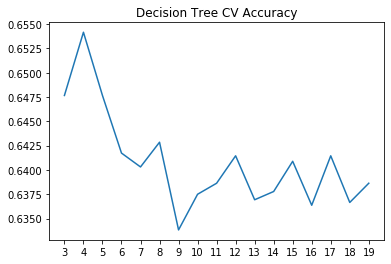

In [193]:
scoresDT = crossValidationDT(X_train, y_train, range(3,20), "Decision Tree CV Accuracy")

In [191]:
# define dt model
dt = tree.DecisionTreeClassifier(max_depth=4)
modeldt = modelEval(X_train, y_train, X_test, y_test, dt, "dt")

train accuracy: 0.6677018633540373
test accuracy: 0.6550362080315998
train f-score: 0.5619650167473019
test f-score: 0.5683690280065897


# Gradient Tree Boosting

In [241]:
# # cross validation
# def crossValidationXGB(X_train, y_train, hyperparameters, title):
#     scores = []
#     for h in hyperparameters:
#         model = tree.RandomForestClassifier(max_depth=h) #penalty='elasticnet', solver="saga", l1_ratio = 0.3)
#         scores.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10).mean())
    
#     plt.plot(hyperparameters,scoresDT)
#     plt.xticks(hyperparameters)
#     plt.title(title)
#     plt.show()
#     return scores

In [213]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [255]:
xgb_model= xgb.XGBClassifier(max_depth=2, reg_lambda=0.5, reg_alpha=0.5)
modelxgb = modelEval(X_ttrain, y_ttrain, X_tval, y_tval, xgb_model, "xgb")

[21:22:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1094: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train accuracy: 0.7444405224144017
test accuracy: 0.6516220028208745
train f-score: 0.7322485207100591
test f-score: 0.627450980392157


# Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

In [65]:
# cross validation
def crossValidationLR(X_train, y_train, hyperparameters, title):
    scores = []
    for h in hyperparameters:
        model = LogisticRegression(max_iter=20000, C=h) 
        scores.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10).mean())
    
    plt.plot(hyperparameters,scores)
    plt.xticks(hyperparameters)
    plt.title(title)
    plt.show()
    return scores

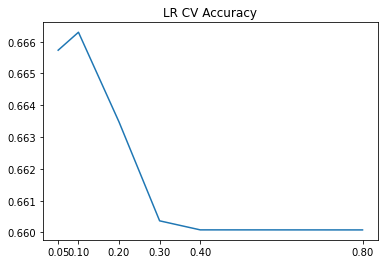

In [68]:
scoresLR = crossValidationLR(X_train, y_train.ravel(), [0.05, 0.1, 0.2, 0.3, 0.4, 0.8], "LR CV Accuracy")

In [67]:
model = LogisticRegression(max_iter=20000, C=0.1)
lr = modelEval(X_train, y_train.ravel(), X_test, y_test.ravel(), model, "lr")

train accuracy: 0.6804065499717674
test accuracy: 0.6616194865042792
train f-score: 0.6724537037037036
test f-score: 0.6605019815059445


# Fully Connected Neural Network version 1

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
from datetime import datetime
import glob, os

In [124]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, features, labels): #labels will be numpy (n,)
        'Initialization'
        self.features = torch.tensor(features, dtype=torch.float) #instance variables
        self.labels = torch.tensor(labels.reshape(-1,1), dtype=torch.float)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.features[index]
        y = self.labels[index]

        return X, y
    
    def getFeatures(self):
        return self.features

In [185]:
# create model class
class NeuralNetwork(nn.Module):
    """
    Simplr neural network to intake
    """
    
    def __init__(self, p, hid, drop_rate):
        super(NeuralNetwork, self).__init__()
        self.hidden = hid
        self.dropout_rate = drop_rate
        self.linear1 = nn.Linear(p, self.hidden, bias=True)  
        self.linear2 = nn.Linear(self.hidden, self.hidden, bias=True) 
        self.linear3 = nn.Linear(self.hidden, 1, bias=True)
        
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.linear1, 
            nn.ReLU(), 
            nn.BatchNorm1d(self.hidden),
            nn.Dropout(p=self.dropout_rate), 
            self.linear2, 
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate),
            self.linear3,
            nn.Sigmoid()
        )

        return model(x)

In [200]:
# create function for training (similar to hw8)
def train(X_train_all, y_train_all, X_test, y_test, model, batch_size, num_epochs, criterion, optimizer):
    loss_curve = []
    accuracy_curve = []
    val_accuracy_curve = []
    # create train test split
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)
    dataloader = DataLoader(Dataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs): # loop over each epoch
        epoch_loss = 0
        total = 0
        correct = 0
        
        for data in dataloader: # loop over each batch
            embeddings, labels = data
            outputs = model(embeddings.float())
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # save train performance
            epoch_loss+=loss.item()
            preds = 1*(outputs>0.5)
            correct += (preds.reshape(-1,1) == labels).sum().item()
            total += float(len(labels))
        
        # train loss and accuracy
        epoch_loss = epoch_loss / len(dataloader)
        epoch_accuracy = correct / total
        loss_curve.append(epoch_loss)
        accuracy_curve.append(epoch_accuracy)
        
        # validation accuracy 
        X_val_t = torch.tensor(X_val, dtype=torch.float) #instance variables
        y_val_t = torch.tensor(y_val.reshape(-1,1), dtype=torch.float)
        val_outputs = model(X_val_t.float())
        val_preds = 1*(val_outputs>0.5)
        val_accuracy = (val_preds.reshape(-1,1) == y_val_t).sum().item()/len(y_val_t)
        val_accuracy_curve.append(val_accuracy)
        
        # test accuracy 
        X_test_t = torch.tensor(X_test, dtype=torch.float) #instance variables
        y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float)
        test_outputs = model(X_test_t.float())
        test_preds = 1*(test_outputs>0.5)
        test_accuracy = (test_preds.reshape(-1,1) == y_test_t).sum().item()/len(y_test_t)
        
        print('epoch [{}/{}], mean epoch loss:{:.4f}, train acc:{:.4f}, val acc:{:.4f}, test acc:{:.4f}'.format(
            epoch + 1, num_epochs, epoch_loss, epoch_accuracy, val_accuracy, test_accuracy))
        
    return model, loss_curve, val_accuracy_curve

In [201]:
# initiate other inputs
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()

# train models - only using title
num_epochs = 50
model = NeuralNetwork(X_ttrain.shape[1],128,0.6)
optimizer = optim.Adam(model.parameters(), lr=0.3e-3)
model, loss_curve, val_acc = train(X_ttrain, y_ttrain, X_test, y_test, 
                                                 model, batch_size, num_epochs, criterion, optimizer)

epoch [1/50], mean epoch loss:0.6715, train acc:0.5830, val acc:0.6614, test acc:0.6445
epoch [2/50], mean epoch loss:0.6383, train acc:0.6324, val acc:0.6543, test acc:0.6695
epoch [3/50], mean epoch loss:0.6291, train acc:0.6434, val acc:0.6437, test acc:0.6643
epoch [4/50], mean epoch loss:0.6281, train acc:0.6487, val acc:0.6702, test acc:0.6577
epoch [5/50], mean epoch loss:0.6229, train acc:0.6527, val acc:0.6578, test acc:0.6557
epoch [6/50], mean epoch loss:0.6159, train acc:0.6527, val acc:0.6878, test acc:0.6596
epoch [7/50], mean epoch loss:0.6088, train acc:0.6650, val acc:0.6702, test acc:0.6643
epoch [8/50], mean epoch loss:0.6027, train acc:0.6708, val acc:0.6596, test acc:0.6616
epoch [9/50], mean epoch loss:0.6016, train acc:0.6575, val acc:0.6473, test acc:0.6728
epoch [10/50], mean epoch loss:0.5977, train acc:0.6642, val acc:0.6596, test acc:0.6656
epoch [11/50], mean epoch loss:0.5915, train acc:0.6743, val acc:0.6543, test acc:0.6570
epoch [12/50], mean epoch loss

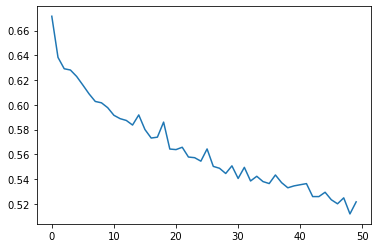

In [203]:
plt.plot(loss_curve)
plt.show()